In [1]:
# --> Install necessary packages
!pip3 install --quiet "pytorch-lightning" "thop" "wandb"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
libcugraph-cu12 25.6.0 req

NOTE: Oversampling path shall be disabled until the final experiment execution begins, as this is to reduce the time and storage that are needed for this

In [2]:
import os
import time
import random
import wandb
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import tabulate
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

%matplotlib inline
from types import SimpleNamespace
from IPython.display import display
from torchmetrics.functional import accuracy
from sklearn.model_selection import train_test_split
from PIL import Image
from torchvision import transforms, datasets
from torchvision.models import efficientnet_b0
from torch.utils.data import random_split, DataLoader, Dataset
from tensorboard.backend.event_processing import event_accumulator
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger, WandbLogger
from pytorch_lightning import LightningDataModule
from kaggle_secrets import UserSecretsClient
from thop import profile

pl.seed_everything(42)
NUM_WORKERS = os.cpu_count()

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [3]:
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb_api")

wandb.login(key=secret_value_0)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: yoga-sugitha22 (yoga-sugitha22-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
## Should be adjusted for the end-to-end experiment
DATASET_NORMAL_PATH = "/kaggle/input/daisee-conf-det-dummy/cnn_dataset_normal-20251113T104849Z-1-001/cnn_dataset_normal/train"
DATASET_UNDERSAMPLING_PATH = "/kaggle/input/daisee-conf-det-dummy/cnn_dataset_undersampling-20251113T104849Z-1-001/cnn_dataset_undersampling/train"
# DATASET_OVERSAMPLING_PATH = "/kaggle/input/cnn-dataset-oversampling/cnn_dataset_oversampling/train"

### WOrktable

In [5]:
full_dataset = datasets.ImageFolder(root=DATASET_UNDERSAMPLING_PATH)
paths = [sample[0] for sample in full_dataset.imgs]  # file paths
labels = [sample[1] for sample in full_dataset.imgs]  # class indices
class_names = full_dataset.classes
class_names

['0_tidak_bingung', '1_bingung']

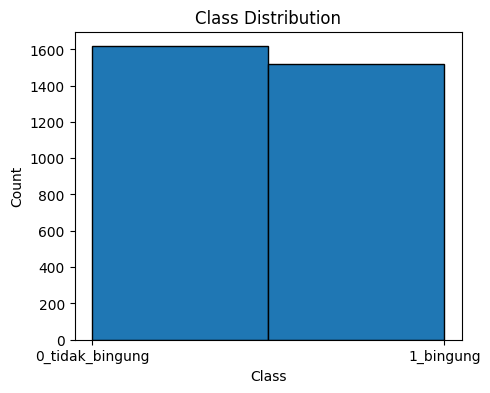

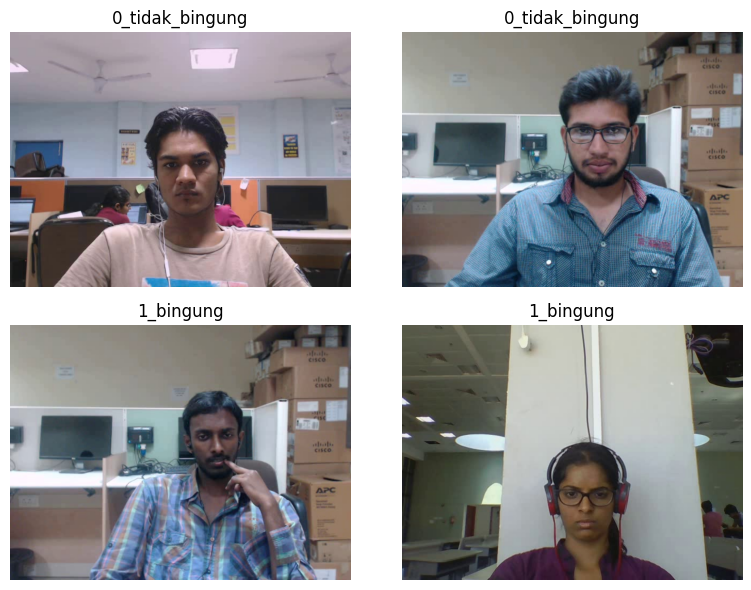

In [6]:
# --- Plot class distribution ---
plt.figure(figsize=(5, 4))
plt.hist(labels, bins=len(class_names), edgecolor='black')
plt.xticks(np.arange(len(class_names)), class_names)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# --- Visualize 2 samples per class ---
samples_per_class = 2
fig, axes = plt.subplots(nrows=2, ncols=samples_per_class, figsize=(8, 6))

for i, class_idx in enumerate(range(len(class_names))):
    # Get indices of samples from this class
    class_indices = [idx for idx, label in enumerate(labels) if label == class_idx]
    # Randomly select 2 images
    chosen_indices = random.sample(class_indices, samples_per_class)
    for j, idx in enumerate(chosen_indices):
        img_path = paths[idx]
        img = plt.imread(img_path)
        ax = axes[i, j]
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(class_names[class_idx])
        
plt.tight_layout()
plt.show()

In [7]:
class ImagePathDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

In [8]:
class DataModule(LightningDataModule):
    def __init__(self, data_dir, preproc_type ="Normal", batch_size=32, test_size=0.2, val_size=0.25, random_state=42):
        super().__init__()
        self.data_dir = data_dir
        self.preproc_type = preproc_type
        self.batch_size = batch_size
        self.test_size = test_size
        self.val_size = val_size
        self.random_state = random_state
        self.train_set = None
        self.val_set = None
        self.test_set = None

    def setup(self, stage:str=None):
        # Step 1: Load full
        full_dataset = datasets.ImageFolder(root=DATASET_NORMAL_PATH)
        paths = [sample[0] for sample in full_dataset.imgs]  # file paths
        labels = [sample[1] for sample in full_dataset.imgs]  # class indices

        # Step 2: Stratified split
        # First split: separate test set (e.g., 20%)
        train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
            paths, labels, test_size=0.2, stratify=labels, random_state=42
        )
        
        # Second split: split remaining into train and val (e.g., 75% of remaining → 60% train, 20% val)
        train_paths, val_paths, train_labels, val_labels = train_test_split(
            train_val_paths, train_val_labels, test_size=0.25, stratify=train_val_labels, random_state=42
        )

        # Define transforms
        transform_train = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomResizedCrop((224,224), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
            transforms.ToTensor(),
        ])
        transform_eval = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])

        # Define the stage; fit --> train and val, test --> test
        if stage=="fit":
            self.train_dataset = ImagePathDataset(train_paths, train_labels, transform=transform_train)
            self.val_dataset = ImagePathDataset(val_paths, val_labels, transform=transform_eval)
            
        if stage=="test":
            self.test_dataset = ImagePathDataset(test_paths, test_labels, transform=transform_eval)
            

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

In [9]:
dm_under = DataModule(data_dir=DATASET_UNDERSAMPLING_PATH, preproc_type="Undersampling")
dm_under.setup()

## Model Initialization

#### Model dissection for later ablation studies

In [10]:
# model = efficientnet_b0(weights="IMAGENET1K_V1")
# print(model) # --- too long

In [11]:
# for name, module in model.features.named_children():
#     print(name, module)

In [12]:
# for name, module in model.features.named_children():
#     print(name, module)

In [13]:
class EEffModelTF(nn.Module):
    def __init__(self, num_classes=2, c_m=512, act_fn=nn.SiLU, dropout=0.5):
        super().__init__()
        self.base = efficientnet_b0(weights='DEFAULT')
        self.base.classifier = nn.Identity() # --> acts as a placeholder that effectively "removes" a layer's functionality while maintaining the structural integrity of the nn.Module hierarchy
        self.fc = nn.Sequential(
            nn.Linear(1280, c_m),
            act_fn(),
            nn.Dropout(p=dropout),
            nn.Linear(c_m,1),
        )

    def forward(self, x):
        x = self.base(x)
        x = self.fc(x)
        return x

    def get_model_metrics(self, input_size=(1, 3, 224, 224)):
        """Calculate model metrics: params, FLOPs, inference time"""
        device = next(self.parameters()).device
        dummy_input = torch.randn(input_size).to(device)
        
        # Count parameters
        num_params = sum(p.numel() for p in self.parameters())
        
        # Calculate FLOPs
        flops, _ = profile(self, inputs=(dummy_input,), verbose=False)
        
        # Measure inference time
        self.eval()
        with torch.no_grad():
            start_time = time.time()
            for _ in range(100):  # Average over 100 inferences
                _ = self(dummy_input)
            end_time = time.time()
        avg_inference_time = (end_time - start_time) / 100
        
        return {
            'num_params': num_params,
            'flops': flops,
            'avg_inference_time': avg_inference_time
        }

In [14]:
model_dict = {}

def create_model(model_name, model_hparams):
    if model_name in model_dict:
        return model_dict[model_name](**model_hparams)
    else:
        assert False, f'Unknown model name "{model_name}". Available models are: {str(model_dict.keys())}'

In [15]:
class EffNetModule(pl.LightningModule):
    def __init__(self, model_name, model_hparams, optimizer_name, optimizer_hparams):
        super().__init__()
        self.save_hyperparameters()
        self.model = create_model(model_name, model_hparams)
        self.loss_module = nn.BCEWithLogitsLoss()

    def forward(self, imgs): # classifier use this
        return self.model(imgs)

    def configure_optimizers(self):
        if self.hparams.optimizer_name == "Adam":
            optimizer = optim.Adam(self.parameters(), **self.hparams.optimizer_hparams)
        elif self.hparams.optimizer_name == "SGD":
            optimizer = optim.SGD(self.parameters(), **self.hparams.optimizer_hparams) 
        else:
            assert False, f'Unknown optimizer: "{self.hparams.optimizer_name}"'
        
        scheduler = {
            "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode="min", factor=0.1, patience=3, verbose=True
            ),
            "monitor": "val_loss",  # crucial for Lightning
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        labels = labels.float().unsqueeze(1)
        preds = self.model(imgs)
        loss = self.loss_module(preds, labels)
        
        acc = ((torch.sigmoid(preds) > 0.5).float().squeeze() == labels.squeeze()).float().mean()
        
        self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        labels = labels.float().unsqueeze(1)
        preds = self.model(imgs)
        loss = self.loss_module(preds, labels)
        
        acc = ((torch.sigmoid(preds) > 0.5).float().squeeze() == labels.squeeze()).float().mean()
        
        self.log("val_loss", loss, on_step=False, on_epoch=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=True)
        return {"val_loss": loss, "val_acc": acc}

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        labels = labels.float().unsqueeze(1)
        preds = self.model(imgs)
        acc = ((torch.sigmoid(preds) > 0.5).float().squeeze() == labels.squeeze()).float().mean()
        
        self.log("test_acc", acc, prog_bar=True)
        return {"test_acc": acc}

In [16]:
act_fn_by_name = {"tanh": nn.Tanh, "relu": nn.ReLU, "leakyrelu": nn.LeakyReLU, "gelu": nn.GELU, "silu": nn.SiLU}

In [17]:
def train_single_experiment(model_name, dataset_name, optimizer_name, model_hparams, 
                           optimizer_hparams, data_module, 
                           seed=42, max_epochs=100):
    """Train a single experiment with a specific seed using LightningDataModule"""
    pl.seed_everything(seed)
    
    # Create experiment name
    experiment_name = f"{model_name}_{dataset_name}_{optimizer_name}_seed{seed}"
    
    # Initialize WandB logger
    wandb_logger = pl.loggers.WandbLogger(
        name=experiment_name,
        project="ACRIG-DAiSEE-confusion_detection",
        config={
            "model_name": model_name,
            "dataset_name": dataset_name,
            "optimizer_name": optimizer_name,
            "model_hparams": model_hparams,
            "optimizer_hparams": optimizer_hparams,
            "seed": seed,
            "max_epochs": max_epochs
        }
    )
    
    # Create trainer
    trainer = pl.Trainer(
        default_root_dir=f"checkpoints/{experiment_name}",
        accelerator="auto",
        devices=1,
        max_epochs=max_epochs,
        logger=wandb_logger,
        callbacks=[
            ModelCheckpoint(
                save_weights_only=True, 
                mode="max", 
                monitor="val_acc",
                dirpath=f"checkpoints/{experiment_name}",
                filename="best-checkpoint"
            ),
            LearningRateMonitor("epoch"),
            EarlyStopping(monitor="val_loss", mode="min", patience=5)
        ],
        log_every_n_steps=10,
        enable_checkpointing=True
    )
    
    # Create and train model
    model = EffNetModule(
        model_name=model_name,
        model_hparams=model_hparams,
        optimizer_name=optimizer_name,
        optimizer_hparams=optimizer_hparams
    )
    
    # Train using the data module
    trainer.fit(model, datamodule=data_module)
    
    # Test using the data module
    test_result = trainer.test(model, datamodule=data_module, verbose=False)
    
    # Calculate model metrics
    model_metrics = model.model.get_model_metrics()
    
    # Log model metrics to WandB
    wandb_logger.experiment.log({
        'num_params': model_metrics['num_params'],
        'flops': model_metrics['flops'],
        'avg_inference_time': model_metrics['avg_inference_time'],
        'final_test_acc': test_result[0]['test_acc']
    })
    
    # Close WandB run
    wandb_logger.experiment.finish()
    
    return {
        'test_acc': test_result[0]['test_acc'],
        'model_metrics': model_metrics
    }

In [18]:
model_dict["efficientnet_b0"] = EEffModelTF

In [19]:
effnet_model, effnet_results = train_single_experiment(
    model_name="efficientnet_b0", 
    dataset_name="Daisee_undersampling", 
    optimizer_name="Adam", 
    model_hparams={"num_classes":2, "act_fn":nn.ReLU, "c_m":256}, 
    optimizer_hparams={"lr":1e-4}, 
    data_module=dm_under, 
    seed=42, 
    max_epochs=50
)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 143MB/s]
wandb: Tracking run with wandb version 0.21.0
wandb: Run data is saved locally in ./wandb/run-20251113_140538-j9bqpiuz
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run efficientnet_b0_Daisee_undersampling_Adam_seed42
wandb: ⭐️ View project at https://wandb.ai/yoga-sugitha22-/ACRIG-DAiSEE-confusion_detection
wandb: 🚀 View run at https://wandb.ai/yoga-sugitha22-/ACRIG-DAiSEE-confusion_detection/runs/j9bqpiuz
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | model       | EEffModelTF       | 4.3 M  | train
1 | loss_mod

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:  avg_inference_time ▁
wandb:               epoch ▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇█
wandb:      final_test_acc ▁
wandb:               flops ▁
wandb:             lr-Adam ████████▁
wandb:          num_params ▁
wandb:            test_acc ▁
wandb:           train_acc ▁▃▃▃▄▄▆▇█
wandb:          train_loss █▇▆▆▅▄▄▃▁
wandb: trainer/global_step ▁▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇████
wandb:             val_acc ▅▆▇█▁▄▁▁▃
wandb:            val_loss ▃▂▂▁▃▄▆█▇
wandb: 
wandb: Run summary:
wandb:  avg_inference_time 0.03144
wandb:               epoch 9
wandb:      final_test_acc 0.71061
wandb:               flops 414192960.0
wandb:             lr-Adam 1e-05
wandb:          num_params 4335741
wandb:            test_acc 0.71061
wandb:           train_acc 0.79828
wandb:          train_loss 0.42945
wandb: trainer/global_step 819
wandb:             val_acc 0.69897
wandb:            val_loss 0.64061
wandb: 
wan